# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

In [182]:
# For some reason, importing this first doesn't crash the kernel

import torch
import torch.nn as nn
import onnx
torch.manual_seed(0)

In [183]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Custom Modules.
from src.modules.game import Game
from src.modules.cards import Card, SuitEnum

from src.deep_learning.modules import Net, Trainer

from src.deep_learning.utils.viz import gen_value_tensor, gen_action_tensor, plot_mesh, gen_all_states, show_action_table
from src.deep_learning.utils.replay_buffer import generate_state_action_pairs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [185]:
rules = {
    "dealer_hit_soft17": False,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
    "split_any_ten": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

## Deep Q Learning

The Q learning without without Neural Networks is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

---

In Deep Q Learning, we are approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE (I actually use Huber Loss) between Temporal Difference Q values of current and future states. We will ultimately be regressing the Q value for each possible action for a given state.

As proposed by Deepmind, we make use of a **target network** and a **q network**.

This is because, we are otherwise chasing a non-stationary target in the Q(s,a) values.

Given state $s$, we use the **q network** to compute the $Q(s,a)$ values for each action. At the same time, the **target network** uses the next state $s`$ to compute $Q(s`,a)$ for the TD target. $Q(s`,a)$ doesn't always have meaning, as taking an action in $s$ might lead us to a terminal state. In this instance, we simply look at the reward. After $M$ rounds, we copy the parameters of the **q network** over to the **target network**.
 
We can implement **experience replay**, where we store the agent's past experience in a deque and sample from this during training. So, in each epoch, simulate a round of gameplay, and store the following, there are 2 means of doing this. I'll touch on this in the **Action Masking** section.

---

### Action Masking
I want a way to implement action masking. I need this because not every action is accessible from every state. I can try this 2 different ways:
- Explicitly mask outputs based on state. Constrain the action space to only valid actions.
- Implicitly learn this mask by penalizing outcomes that select an invalid action. I've found that too severe of penalties, experienced early in training during exploration, makes it incredibly hard to recover these later on. Small negative rewards are given to these.


The SARSA approach (State, Action, Reward, State', Action'):

$$(state, possible\_actions, action, reward, done, new\_state, possible\_actions\_new)$$

#### Explicit Masking
My first attempt at handling this is by explicitly doing action masking for both **target network** and **q network**, where I have access to possible actions, and I can mask invalid ones by forcing model outputs to $-inf$. This will have the impact that in both $argmax$ and $softmax$, they will be unreachable actions and will never be used for $Q(s`,a)$ or $Q(s,a)$ action selections. Until I find a better method for this, I don't particularly like it. $Q(s,a)$ values for unreachable states are quite high even for unreachable states, and it seems to pull from the actual meaningful $Q(s,a)$ values for valid states. Remember, we still produce Q values for these invalid states in the `forward()` pass, they are just masked downstream.

The model inputs are:
$$(player\_total, house\_shows, useable\_ace)$$


#### Implicit Masking
My next approach is to implicitly penalize selections to invalid states. Given that $can\_split, can\_double$ are parts of the input space, the network should feasibly be able to differentiate when it can and cannot split + double. In the replay buffer, if we select an invalid action, we immediately stop gameplay simulation and add a response with a negative reward. I'll call this the **misstep** penalty, and it's actually a rather important hyperparameter to adjust.

The model inputs are:
$$(player\_total, house\_shows, useable\_ace, can\_split, can\_double)$$

note the additional 2 fields, to condition the model to understand its state in a more complete manner.


### Empirical Findings

After evaluating both, I decided to use a combination of the 2 above. I used the following model input:

$$(player\_total, house\_shows, useable\_ace, can\_split, can\_double)$$

And on top of this, I explicitly masked invalid states from the model training process. So, the model will never select an invalid action while generating the replay buffer. **Issue** was the model completely seemed to ignore the features for `can_split` and `can_double` and it worsened performance. The model was convergence to essentially compute the same q value for all states...

I ended up moving forward with the **Explicit Masking** approach, given empirical findings. 

In [196]:
def get_decay_factor(max_val, min_val, n):
    return np.log(max_val / min_val) / n

def get_current_decay_value(max_val, decay_factor, n):
    return max_val * np.exp(-decay_factor * n)

REPLAY_SIZE = 10_000
MIN_REPLAY_SIZE = 1_000 # this won't be hit exactly due to splitting during gameplay.
GAMMA = 0.95

TARGET_UPDATE_FREQ = 5_000
N_EPOCHS = 1_000_000
EVAL_EVERY = 10_000
BATCH_SIZE = 16

LR = 0.001
LR_MIN = 0.0001
EPS_MIN = .1

EPS_DECAY = get_decay_factor(1, EPS_MIN, N_EPOCHS)
LR_DECAY = get_decay_factor(LR, LR_MIN, N_EPOCHS)

USE_COUNT = False

method = "softmax" # can be epsilon or softmax.

In [197]:
# Forcefully inject infrequently visited player card combos during training.

cards_force = []
for c in [2,3,4,5,6,7,8,9,10,"A"]:
    cards_force.append([Card(suit=SuitEnum.clubs, card=c) for _ in range(2)])
for c in [2,3,4,5,6,7,8,9,10]:
    cards_force.append([Card(suit=SuitEnum.clubs, card="A"), Card(suit=SuitEnum.clubs, card=c)])

In [198]:
hidden_layers = [50, 25]

input_dim = 3 + 0 + int(USE_COUNT)
online_net = Net(input_dim, hidden_layers=hidden_layers)
target_net = Net(input_dim, hidden_layers=hidden_layers)

trainer = Trainer(
    online_net=online_net,
    target_net=target_net,
    replay_size=REPLAY_SIZE,
    include_count=USE_COUNT,
)

# loss_fct = nn.SmoothL1Loss()
loss_fct = nn.MSELoss()
optimizer = torch.optim.Adam(online_net.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=(1 - LR_DECAY))

trainer.copy_online_to_target()

In [199]:
blackjack = Game(**game_hyperparams)

mean_rewards = []
training_loss = []

# first randomly generate our replay_buffer.
# I want to isolate this so it doesn't eat away at the epochs
# used towards training.
replay_sufficient = False
while not replay_sufficient:
    trainer.update_buffer(blackjack=blackjack, method="random")
    replay_sufficient = len(trainer.replay_buffer.memory) >= MIN_REPLAY_SIZE


for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = get_current_decay_value(1, EPS_DECAY, step)

    m = method
    if method == "epsilon":
        m = "random" if np.random.sample() < eps else "argmax"

    # forceful injection of infrequent player cards into the initial deal.
    forced_cards = []
    if not step % 10:
        forced_cards_i = np.random.choice(len(cards_force))
        forced_cards = cards_force[forced_cards_i]

    trainer.update_buffer(blackjack=blackjack, method=m, force_cards=forced_cards)

    loss_epoch = trainer.train_epoch(
        batch_size=BATCH_SIZE,
        gamma=GAMMA,
        loss_fct=loss_fct,
        optimizer=optimizer,
        scheduler=scheduler
    )
    training_loss.append(loss_epoch)

    if not (step % TARGET_UPDATE_FREQ):
        trainer.copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await trainer.eval(
            n_games=100,
            n_rounds=50,
            wagers=[1],
            game_hyperparams=game_hyperparams
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}\
 ---- lr {optimizer.param_groups[0]['lr']:.4f}")

network = Net(input_dim, hidden_layers=hidden_layers)

network.load_state_dict(deepcopy(trainer.online_net.state_dict()))
network.eval()

step 0 ---- mean reward per round -0.6866 ---- epoch training loss 2.6652 ---- eps 1.0000 ---- lr 0.0010
step 10000 ---- mean reward per round -0.0435 ---- epoch training loss 0.6623 ---- eps 0.9772 ---- lr 0.0010
step 20000 ---- mean reward per round 0.0049 ---- epoch training loss 0.2709 ---- eps 0.9550 ---- lr 0.0010
step 30000 ---- mean reward per round -0.0578 ---- epoch training loss 1.3671 ---- eps 0.9333 ---- lr 0.0009
step 40000 ---- mean reward per round -0.0531 ---- epoch training loss 0.4675 ---- eps 0.9120 ---- lr 0.0009
step 50000 ---- mean reward per round -0.0344 ---- epoch training loss 0.6884 ---- eps 0.8913 ---- lr 0.0009
step 60000 ---- mean reward per round -0.0228 ---- epoch training loss 1.4125 ---- eps 0.8710 ---- lr 0.0009
step 70000 ---- mean reward per round -0.0248 ---- epoch training loss 0.4306 ---- eps 0.8511 ---- lr 0.0009
step 80000 ---- mean reward per round -0.0149 ---- epoch training loss 0.6254 ---- eps 0.8318 ---- lr 0.0008
step 90000 ---- mean rew

Net(
  (fc_input): Linear(in_features=3, out_features=50, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=50, out_features=25, bias=True)
  )
  (fc_output): Linear(in_features=25, out_features=5, bias=True)
)

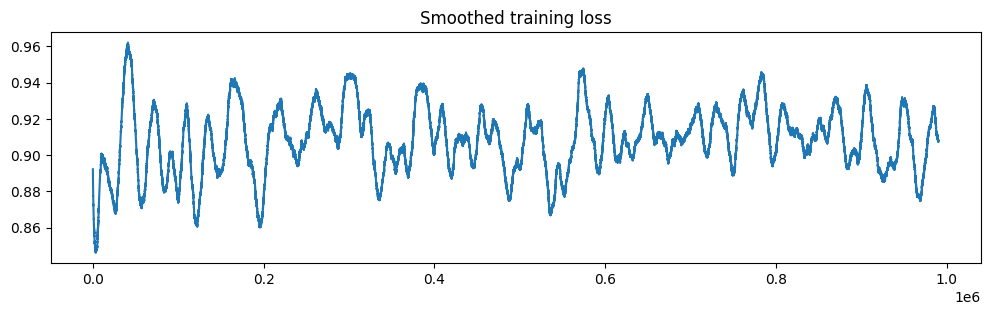

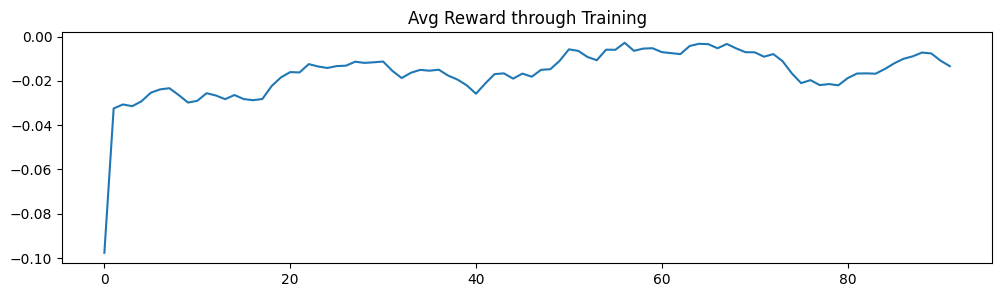

In [200]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(10000)/10000, mode="valid"))
plt.title("Smoothed training loss")
# plt.vlines(range(len(training_loss))[::1000], ymin=.25, ymax=.55)
plt.show()

plt.figure(figsize=(12,3))
plt.plot(np.convolve(mean_rewards, np.ones(10)/10, mode="valid"))
plt.title("Avg Reward through Training")
plt.show()

In [202]:
torch.save(network.state_dict(), "./models/deep_q.pt")

torch.onnx.export(
    network,
    torch.tensor([5,11,-1], dtype=torch.float32),
    "./models/deep_q.onnx"
)

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [93]:
network =  Net(input_dim, hidden_layers=hidden_layers)
network.load_state_dict(torch.load("./models/deep_q.pt"))
network.eval()

Net(
  (fc_input): Linear(in_features=5, out_features=100, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=100, out_features=50, bias=True)
  )
  (fc_output): Linear(in_features=50, out_features=5, bias=True)
)

In [285]:
all_states = gen_all_states()

no_ace_no_split = list(filter(lambda x : x[2] < 0, all_states))
yes_ace_no_split = list(filter(lambda x : x[2] > 0, all_states))
yes_split = list(filter(lambda x : (not x[0] % 2) and ((x[2] < 0) or (x[0] == 12)), all_states))

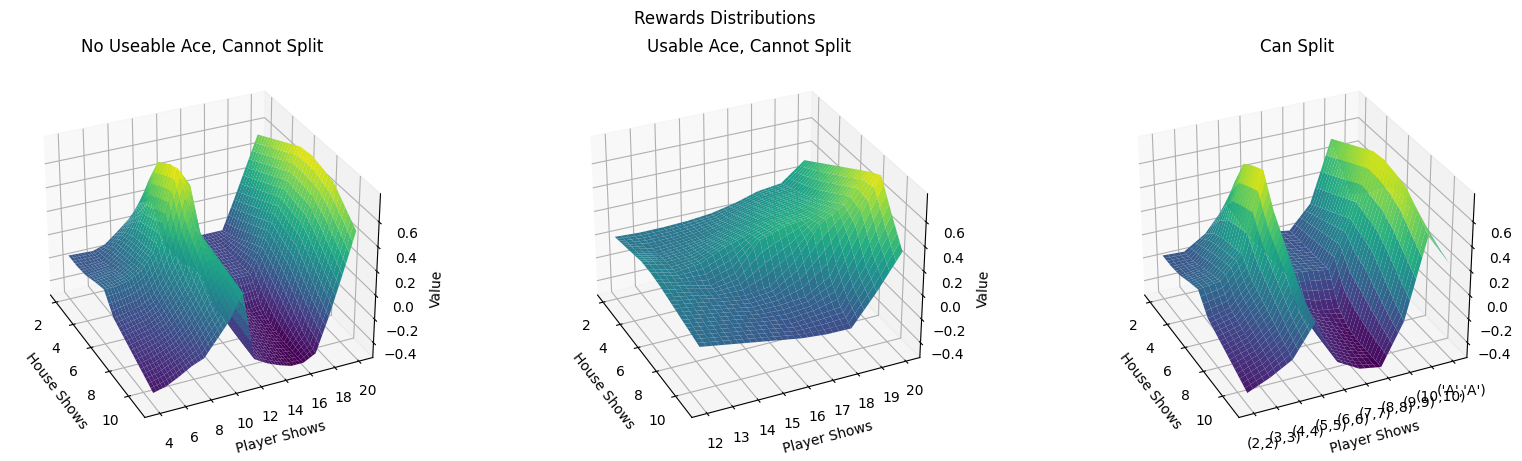

In [286]:
value_det_0, min_0, max_0 = gen_value_tensor(model=network, data=no_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])
value_det_1, min_1, max_1 = gen_value_tensor(model=network, data=yes_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])
value_det_2, min_2, max_2 = gen_value_tensor(model=network, data=yes_split, avail_actions=["hit", "stay", "double", "split", "surrender"])


min_use = np.min([min_0, min_1, min_2])
max_use = np.max([max_0, max_1, max_2])


fig = plt.figure(figsize=(20,5))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(
    axis=ax,
    data=value_det_0,
    interpolate=4,
    ticks=None,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(
    axis=ax,
    data=value_det_1,
    interpolate=4,
    ticks=None,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(
    axis=ax,
    data=value_det_2,
    interpolate=4,
    ticks=ticks,
    zlims=[min_use, max_use],
    vmin=min_use,
    vmax=max_use
)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

In [288]:
value_action = gen_action_tensor(model=network, data=no_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])

print("No Useable Ace, Can't Split")
show_action_table(value_action)

No Useable Ace, Can't Split


,2,3,4,5,6,7,8,9,10,11
4,St,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
5,St,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
6,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
7,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
8,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
9,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi
10,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi
11,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi
12,St,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
13,St,St,St,St,Hi,Hi,Hi,Hi,Hi,Hi


In [289]:
value_action = gen_action_tensor(model=network, data=yes_ace_no_split, avail_actions=["hit", "stay", "double", "surrender"])

print("Yes Useable Ace, Can't Split")
show_action_table(value_action)

Yes Useable Ace, Can't Split


,2,3,4,5,6,7,8,9,10,11
12,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
13,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
14,Hi,Hi,Hi,Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
15,Hi,Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi,Hi
16,Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi,Hi
17,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi,Hi
18,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/St,Do/St,Do/St,St,St,Hi
19,Do/St,Do/St,Do/St,St,St,St,St,St,St,St
20,St,St,St,St,St,St,St,St,St,St


In [290]:
value_action = gen_action_tensor(model=network, data=yes_split, avail_actions=["hit", "stay", "double", "split", "surrender"])

print("Can Split")
show_action_table(value_action, xticks=[(p,p) if p < 11 else ("A","A") for p in range(2,12)])

Can Split


,2,3,4,5,6,7,8,9,10,11
"(2, 2)",St,St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
"(3, 3)",St,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
"(4, 4)",Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi,Hi
"(5, 5)",Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Do/Hi,Hi,Hi
"(6, 6)",Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(7, 7)",Sp,Sp,Sp,Sp,Sp,Hi,Hi,Hi,Hi,Hi
"(8, 8)",Sp,Sp,Sp,Sp,Sp,St,St,Su,Su,Su
"(9, 9)",St,St,St,St,St,St,St,St,St,St
"(10, 10)",St,St,St,St,St,St,St,St,St,St
"('A', 'A')",Hi,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp,Sp


In [100]:
ar = no_ace_no_split
action_space = ["hit", "stay", "double", "surrender", "split"]

actions = [action_space for _ in ar]
with torch.no_grad():
    q, _, action = network.act(torch.tensor(ar, dtype=torch.float32), avail_actions=actions)

for i,r in enumerate(q):
    print(ar[i], r, network.moves[action[i]])

(5, 2, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 3, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 4, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 5, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 6, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 7, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 8, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 9, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 10, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(5, 11, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(6, 2, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(6, 3, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(6, 4, -1, -1, 1) tensor([-0.3345,  0.0265, -0.1205, -0.3142, -0.5000]) hit
(6, 5, -1,